In [1]:
import nibabel
import nibabel as nib  # Useful to load data

import nilearn
from nilearn import datasets
from nilearn.regions import RegionExtractor
from nilearn import plotting
from nilearn.image import index_img
from nilearn.plotting import find_xyz_cut_coords
from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.regions import RegionExtractor
from nilearn import plotting
from nilearn.image import index_img
from nilearn import datasets
from nilearn import plotting

import matplotlib.pyplot as plt

 
from pathlib import Path
import dotenv
import seaborn as sns

import numpy as np
import networkx as nx
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

import gtda
from gtda.images import ImageToPointCloud, ErosionFiltration
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import (
    PersistenceEntropy,
    PersistenceLandscape,
    PersistenceImage,
)
from gtda.pipeline import Pipeline
from gtda.plotting import plot_diagram, plot_point_cloud, plot_heatmap
from gtda.homology import CubicalPersistence
from gtda.diagrams import (
    Scaler,
    Filtering,
    PersistenceEntropy,
    BettiCurve,
    PairwiseDistance,
)
from gtda.mapper import make_mapper_pipeline
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph
)


import os
import tempfile
from urllib.request import urlretrieve
import zipfile

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from skimage import io

import glob
import json

# Import utils library
import utils
%matplotlib inline

In [2]:
DOTENV_KEY2VAL = dotenv.dotenv_values()

In [3]:
directory = DOTENV_KEY2VAL["DATA_DIR"]
image_dir = directory + "/patch_92/"
diagnosis_json = "collected_diagnoses_complete.json"

In [4]:
cn_patients, mci_patients, ad_patients = utils.get_earliest_available_diagnosis(directory + diagnosis_json)
images_all = utils.get_arrays_from_dir(image_dir, cn_patients + mci_patients + ad_patients)

Patient /home/pjh/Documents/Git/TDA_ADNI_MLCB/data//patch_92/sub-ADNI133S1170-M00-MNI.npy had no corresponding array available (no MRI was performed at the time of diagnosis)


In [5]:
# sns.displot(images_all.flatten())

cn_patient_list = [1 for patient in range(len(cn_patients)-1)]#substracting one due to unfound MRI for one CN patient
mci_patient_list = [2 for patient in range(len(mci_patients))]
ad_patient_list = [3 for patient in range(len(ad_patients))]

In [6]:
labels = np.array(cn_patient_list + mci_patient_list + ad_patient_list).reshape(-1,1)

In [7]:
images = []
for image in images_all:
    images.append(image.flatten())
images_all = np.asarray(images)

In [11]:
n_components = 100
pca = PCA(n_components=n_components)
images_all_projected = pca.fit_transform(images_all)

No handles with labels found to put in legend.
/home/pjh/.anaconda/envs/tda_adni_mlcb/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



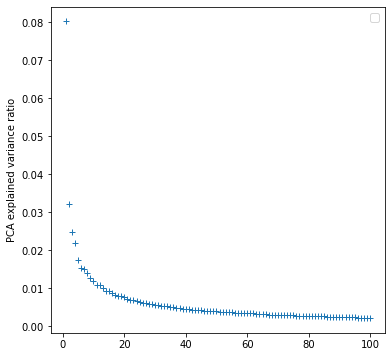

In [12]:
fig, ax0 = plt.subplots(nrows=1, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.legend(prop=dict(size=12))
fig.show()

In [13]:
images_all_projected.shape

(440, 100)

In [41]:
images_all_projected = np.append(images_all_projected, labels, axis=1)

In [42]:
columns = [index for index in range(n_components)]

In [57]:
pipe = make_mapper_pipeline(
        filter_func=Projection(columns=[0,1]),
        cover=CubicalCover(n_intervals=10, overlap_frac=0.25),
        clusterer=DBSCAN(eps=0.5, min_samples=5, n_jobs=-1),
        verbose=True,
        n_jobs=4,
)

In [58]:
fig = plot_static_mapper_graph(pipe, images_all_projected, layout_dim=3, color_by_columns_dropdown=True)
fig.write_html(
        DOTENV_KEY2VAL["GEN_FIGURES_DIR"]
        + "mapper_2_dimensional_reduction.html"
    )
fig.show(config={'scrollZoom': True})

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   3.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


In [52]:
images_all_projected = pd.DataFrame(images_all_projected)

In [53]:
images_all_projected.head()

,0,1,2,3
0,-0.189584,-3.502730,1.781303,1.0
1,-0.293363,-4.574308,-1.226093,1.0
2,-0.275580,-2.425988,-3.934837,1.0
3,3.528377,-3.165854,-2.109851,1.0
4,-1.772906,-7.000118,2.162618,1.0


In [55]:
fig = px.scatter_3d(images_all_projected, x=0, y=1, z=2,
              color=3)
fig.show()